In [15]:
# Import libriaries
import cv2
import numpy as np
import operator
from tqdm import tqdm

In [2]:
class Node:
    def __init__(self, data=None, left=None, right=None, p=0):        
        self.data = data
        self.left = left
        self.right = right
        self.p = p
    
    def __str__(self):
        if self.data == None:
            return "(None,%d)" % (self.p)
        return "(%d,%d)" % (self.data,self.p)
    
    def __repr__(self):
        if self.data == None:
            return "(None,%d)" % (self.p)
        return "(%d,%d)" % (self.data,self.p)

In [3]:
def lower_bound(x, vector):
    if len(vector) == 0:
        return 0
    l = 0
    r = len(vector) - 1
    while(r - l > 1):
        m = (l+r)//2
        if vector[m].p == x:
            return m
        elif x < vector[m].p:
            r = m
        else:
            l = m
            
    if vector[r].p <= x:
        return r
    if vector[l].p <= x:
        return l
    else:
        return 0

In [4]:
def generate_tree(intensities):
    
    if len(intensities) == 0:
        return Node()
    
    while len(intensities) > 1:
        left = intensities[1]
        right = intensities[0]
        node = Node(left=left, right=right, p = (left.p + right.p))
        
        intensities = intensities[2:]
        pos = lower_bound(node.p, intensities)
        intensities.insert(pos, node)
    
    return intensities[0]

In [5]:
def inorder(node, code=""):
    output = ""
    colors = {}
    if (node.left == None) and (node.right == None) and (node.data != None):
        output = ("%s %s\n" % (str(node.data), code))
        colors[node.data] = code
        
    if node.left != None:
        o,c = inorder(node.left, code+"1")
        output += o
        colors.update(c)
    if node.right != None:
        o,c = inorder(node.right, code+"0")
        output += o
        colors.update(c)
        
    return output,colors

In [6]:
def pre_processing(img):
    h,w = img.shape[:2]
    c = 1
    if len(img.shape) > 2:
        c = img.shape[2]
    
    code = {}
    code['width'] = w
    code['height'] = h
    code['channels'] = c
    intensities = [(i,0) for i in range(256)]
    
    return code,intensities

In [7]:
def huffman(img):
    code,intensities = pre_processing(img)
    
    for row in range(code['height']):
        for col in range(code['width']):
            if code['channels'] > 1:
                for c in range(code['channels']):
                    intensity = img[row,col,c]
                    intensities[intensity] = ( intensity, intensities[intensity][1]+1 )
            else:
                intensity = img[row,col]
                intensities[intensity] = ( intensity, intensities[intensity][1]+1 )
    intensities.sort(key = operator.itemgetter(1), reverse=True)
    max_index = 0
    
    code['intensity_p'] = []
    for (i,j) in intensities:
        if j == 0:
            break
        code['intensity_p'].append( Node(data=i,p=j) )
    
    code['intensity_p'].reverse()
    code['tree'] = generate_tree(code['intensity_p'])
    
    return code

In [8]:
def pad_encoded_text(encoded_text):
    extra_padding = 8 - len(encoded_text) % 8
    for i in range(extra_padding):
        encoded_text += "0"
        
    padded_info = "{0:08b}".format(extra_padding)
    encoded_text = padded_info + encoded_text
    return encoded_text

def get_byte_array(padded_encoded_text):
    if(len(padded_encoded_text) % 8 != 0):
        print("Encoded text not padded properly")
        exit(0)

    b = bytearray()
    for i in range(0, len(padded_encoded_text), 8):
        byte = padded_encoded_text[i:i+8]
        b.append(int(byte, 2))
    return b

def compress(img, code, filename):
    f = open(filename + '.vh', 'wb')    
    colors_str, colors_map = inorder(code['tree'])
    encoded_text = ""
    for row in range(code['height']):
        for col in range(code['width']):
            if code['channels'] > 1:
                for c in range(code['channels']):
                    encoded_text += colors_map[ img[row,col,c] ]
            else:
                encoded_text += colors_map[ img[row,col] ]
    encoded_text = pad_encoded_text(encoded_text)
    b = get_byte_array(encoded_text)
    f.write(bytes(b))
    f.close()
    
    f = open(filename + '.config', 'w')
    f.write(str(code['width']) + '\n')
    f.write(str(code['height']) + '\n')
    f.write(str(code['channels']) + '\n')
    f.write(colors_str)
    f.close    

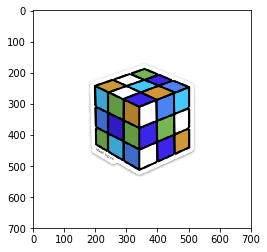

In [22]:
rubiks = cv2.imread('images/rubiks.png')
#rubiks = cv2.cvtColor(rubiks, cv2.COLOR_BGR2RGB)
code = huffman(rubiks)

plt.imshow(rubiks)
plt.show()
compress(rubiks, code, "rubiks")

In [18]:
def get_config(fileconfig):
    code={}
    with open(fileconfig, 'r') as f:
        content = f.read()
        lines = content.split('\n')
        code['width'] = int(lines[0])
        code['height'] = int(lines[1])
        code['channels'] = int(lines[2])
        for line in lines[3:]:
            color_bin = line.split(' ')
            if len(color_bin) >= 2:
                code[color_bin[1]] = color_bin[0]
    return code

def decode(code, config):
    image = np.zeros((config['height'],config['width']), dtype='uint8')
    if config['channels'] > 1:
        image = np.zeros((config['height'],config['width'],config['channels']), dtype='uint8')
    for row in tqdm(range(config['height'])):
        for col in range(config['width']):
            for c in range(config['channels']):
                value = -1
                current = ''
                while(code != ''):
                    current += code[0]
                    code = code[1:]
                    if current in config:
                        value = int(config[current])
                        break
                if config['channels'] > 1:
                    image[row,col,c] = value
                else:
                    image[row,col] = value
    return image

@jit(nopython=True)
def decompress(filename, fileconfig):
    config = get_config(fileconfig)
    with open(filename, 'rb') as f:
        code = ""
        byte = f.read(1)
        while byte != b"":
            # Do stuff with byte.
            code += bin( ord(byte) )[2:].rjust(8, '0')
            byte = f.read(1)    
    result = decode(code, config)
    plt.imshow(result)
    plt.show()

In [19]:
decompress("rubiks.vh", "rubiks.config")

NotDefinedError: Failed in nopython mode pipeline (step: analyzing bytecode)
Variable '$16.2' is not defined.
Unsupported Python functionality was found in the code Numba was trying to
compile. This error could be due to invalid code, does the code work
without Numba? (To temporarily disable Numba JIT, set the `NUMBA_DISABLE_JIT`
environment variable to non-zero, and then rerun the code).

If the code is valid and the unsupported functionality is important to you
please file a feature request at: https://github.com/numba/numba/issues/new

To see Python/NumPy features supported by the latest release of Numba visit:
http://numba.pydata.org/numba-doc/dev/reference/pysupported.html
and
http://numba.pydata.org/numba-doc/dev/reference/numpysupported.html
